In [1]:
## Loding libraries
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
## Preprocecing ##
jh_dir = "../../COVID-19"
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [3]:
## Definitions ##

In [4]:
### dates ###
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-08')
upto = last-pd.Timedelta(days=2)
index= pd.date_range(start=epoch, end=upto)

In [5]:
### Fitting a model ###
def fit_and_infer(sm=None, data=None, country=None, population=None, detection_rate=1,
                  b_beta_0=0.1, inits='random', iteration=2000, start=epoch, last=last):
    if data is None:
        C0 = confirmed.loc[start:last, country].values
        D0 = death.loc[start:last, country].values
        P = population
        data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'D0':D0, 
                'q0':detection_rate, 'b_beta_0':b_beta_0}
    fit = sm.sampling(data=data, iter=iteration, init=inits)
    print(fit)
    return az.from_pystan(fit, log_likelihood='log_lik')

In [6]:
### Extract data ###
def extract_var(var_name=None, data=None, start=epoch):
    d = data.posterior[var_name].stack(sample=('chain', 'draw')).values
    return pd.DataFrame(d, index=pd.date_range(start, end=start+pd.Timedelta(days=len(d)-1)))

In [7]:
### Drawing ###
def draw(data, index=index, name=None, line=None, label_name=None, value_name='value'):
    df = pd.DataFrame()
    dfs = []
    for label, samples in data.items():
        samples['Date'] = samples.index
        melted=pd.melt(samples, id_vars=['Date'])
        if label_name is not None:
            melted[label_name]=label
        dfs.append(melted)
    df = pd.concat(dfs)
    df = df.rename(columns={'value':value_name})
    if label_name is not None:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name, hue=label_name)
    else:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linestyle='--', linewidth=2, alpha=.7)
    g.savefig("{}.pdf".format(name))
    plt.show()

In [8]:
## Compile models ##
sm_const = pystan.StanModel(file="const.stan")
sm_const_q = pystan.StanModel(file="everyday-const-q.stan")
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af9c64d5eae9f5635306a489c55c8d64 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5cd8be6e46ccd02931578633bb84615c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee2085594df7feb36fc67a80a17cc305 NOW.


In [9]:
## Model Validation ##

In [10]:
#### Constant parameters ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

data = simulate(0.07, 0.2, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      87.66    1.27  20.23  53.83  73.34  86.14 100.67 131.37    252   1.02
b_beta       3.4e-3  1.7e-4 1.5e-3 1.3e-3 2.3e-3 3.0e-3 4.2e-3 6.9e-3     80   1.03
b[1]           0.02  2.3e-3   0.03 1.8e-4 1.9e-3 5.6e-3   0.03   0.09    139   1.03
b[2]           0.04  2.5e-3   0.03 6.5e-4 8.4e-3   0.05   0.07    0.1    166   1.03
b[3]           0.07  1.1e-3   0.02   0.03   0.06   0.07   0.08   0.11    312    1.0
b[4]           0.07  8.8e-4   0.02   0.04   0.06   0.07   0.08   0.11    393    1.0
b[5]           0.07  8.2e-4   0.02   0.04   0.06   0.07   0.08   0.11    386    1.0
b[6]           0.07  8.3e-4   0.02   0.04   0.06   0.07   0.08   0.11    359   1.01
b[7]           0.08  8.1e-4   0.02   0.05   0.07   0.08

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      44.06     4.4  37.95  15.15  23.71  32.99  47.86 151.46     74   1.09
b_beta       3.0e-3  4.0e-4 1.5e-3 4.8e-4 2.1e-3 2.8e-3 3.9e-3 6.5e-3     15    1.2
b[1]           0.02  7.2e-3   0.03 7.9e-5 1.6e-3 6.4e-3   0.05   0.09     19   1.17
b[2]           0.05  4.7e-3   0.03 9.5e-4   0.01   0.05   0.07    0.1     49    1.1
b[3]           0.06  3.2e-3   0.03   0.01   0.04   0.07   0.08   0.11     67   1.09
b[4]           0.06  3.0e-3   0.03   0.01   0.05   0.07   0.08   0.11     71   1.09
b[5]           0.07  2.4e-3   0.02   0.02   0.05   0.07   0.08   0.11     95   1.07
b[6]           0.07  2.3e-3   0.02   0.02   0.06   0.07   0.08   0.11    100   1.07
b[7]           0.07  2.2e-3   0.02   0.02   0.06   0.07

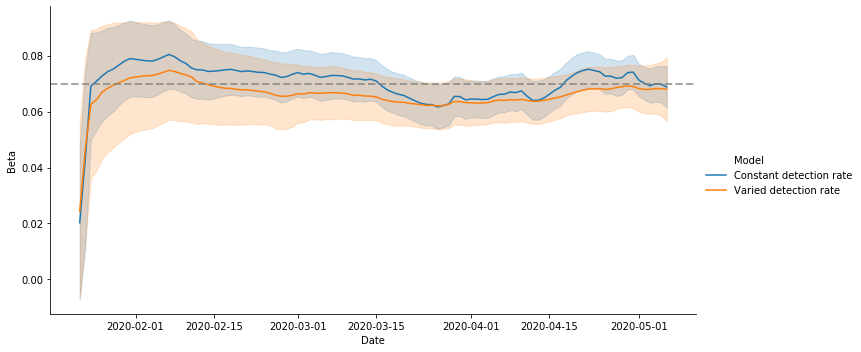

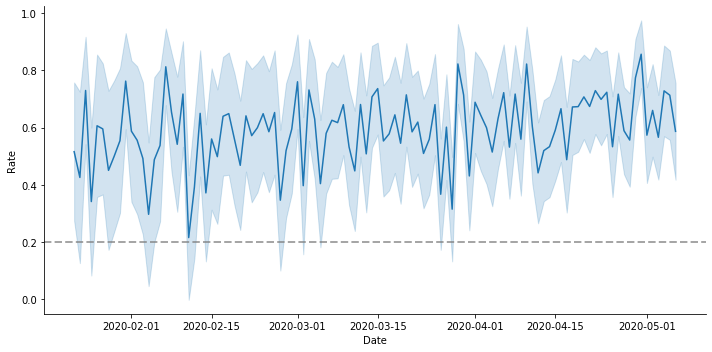

In [11]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='const_beta', line=0.07, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', label_name=None, value_name='Rate')

In [12]:
#### Step-like detection rate ####
from scipy.stats import poisson
def simulate(b, q1, q2, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    D_obs = [0]
    R_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q1}, np.array(q)

data, q_true = simulate(0.07, 1, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       89.8    0.26   9.41  72.43  83.09  89.38  95.92 109.35   1336    1.0
b_beta       4.4e-3  1.2e-4 1.4e-3 2.2e-3 3.3e-3 4.2e-3 5.2e-3 7.6e-3    131   1.04
b[1]           0.07  8.8e-4   0.02   0.01   0.06   0.07   0.08    0.1    556   1.01
b[2]           0.08  4.5e-4   0.01   0.05   0.07   0.08   0.09   0.11   1078   1.01
b[3]           0.08  4.4e-4   0.01   0.06   0.07   0.08   0.09   0.11    862    1.0
b[4]           0.08  4.4e-4   0.01   0.06   0.07   0.08   0.09   0.11    792    1.0
b[5]           0.08  4.2e-4   0.01   0.06   0.07   0.08   0.09   0.11    778    1.0
b[6]           0.08  4.3e-4   0.01   0.06   0.07   0.08   0.09    0.1    733    1.0
b[7]           0.08  4.2e-4   0.01   0.06   0.07   0.08

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     205.78    3.78   85.3  97.88 145.27 186.86  244.6 422.68    508   1.01
b_beta       3.2e-3  1.1e-4 1.2e-3 1.4e-3 2.4e-3 3.0e-3 3.9e-3 6.1e-3    129   1.04
b[1]           0.06  7.9e-4   0.02   0.02   0.05   0.06   0.07    0.1    667   1.01
b[2]           0.07  7.2e-4   0.02   0.03   0.05   0.06   0.08   0.11    694   1.01
b[3]           0.07  7.2e-4   0.02   0.04   0.05   0.07   0.08   0.11    660   1.01
b[4]           0.07  7.3e-4   0.02   0.04   0.05   0.07   0.08    0.1    612   1.01
b[5]           0.07  7.1e-4   0.02   0.04   0.06   0.07   0.08    0.1    605   1.01
b[6]           0.07  7.0e-4   0.02   0.04   0.06   0.07   0.08    0.1    610   1.01
b[7]           0.07  7.0e-4   0.02   0.04   0.06   0.07

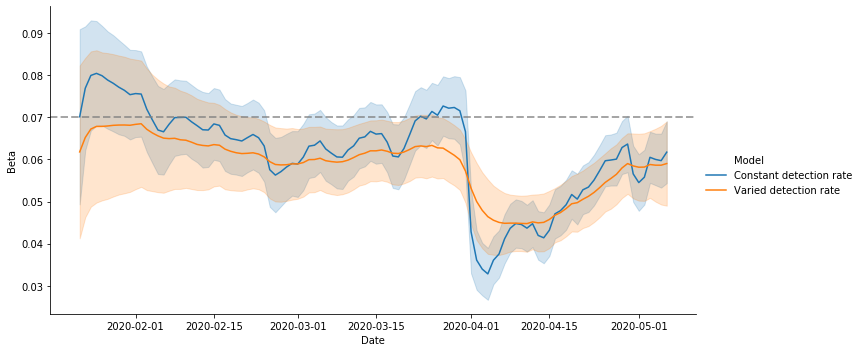

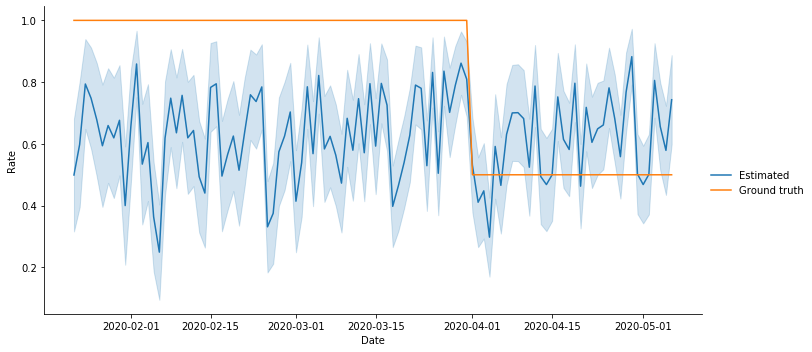

In [13]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
                     
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='step_beta', 
     label_name='Model', value_name='Beta', line=0.07)

q_true = pd.DataFrame(q_true, index)
draw({'Estimated':q, 'Ground truth':q_true}, name='step_q', value_name='Rate', label_name='')

In [14]:
#### Changing beta ####
from scipy.stats import poisson
def simulate(b0, b1, q0, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    q = [q0]
    D_obs = [0]
    R_obs = [0]
    b = [b0]
    for t in index:
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
        q.append(q0 + 0.05*np.random.randn(1)[0])
        b.append(b[-1] - b1)
 
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':1, 'q0':q0}, np.array(q), np.array(b)
data, q_true, b_true = simulate(0.16, 0.001, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     108.44    0.34  14.31  82.13  98.03 108.06 117.83 138.47   1774    1.0
b_beta       8.2e-3  2.5e-5 1.2e-3 6.1e-3 7.3e-3 8.1e-3 8.9e-3   0.01   2110    1.0
b[1]           0.14  6.9e-4   0.03   0.09   0.13   0.14   0.16   0.19   1514    1.0
b[2]           0.15  5.7e-4   0.02    0.1   0.13   0.15   0.16   0.19   1698    1.0
b[3]           0.15  5.2e-4   0.02   0.11   0.14   0.15   0.16   0.19   1630    1.0
b[4]           0.15  5.0e-4   0.02   0.11   0.13   0.15   0.16   0.18   1499    1.0
b[5]           0.15  4.7e-4   0.02   0.11   0.14   0.15   0.16   0.18   1520    1.0
b[6]           0.15  4.3e-4   0.02   0.12   0.14   0.15   0.16   0.18   1546    1.0
b[7]           0.15  4.0e-4   0.02   0.12   0.14   0.15

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     102.53    1.14  34.61  56.45  77.72   96.0 118.96 188.03    925    1.0
b_beta       3.1e-3  6.2e-5 9.3e-4 1.7e-3 2.4e-3 2.9e-3 3.6e-3 5.3e-3    230   1.02
b[1]           0.14  6.1e-4   0.02   0.09   0.12   0.13   0.15   0.18   1236    1.0
b[2]           0.14  5.9e-4   0.02   0.09   0.12   0.14   0.15   0.18   1248    1.0
b[3]           0.14  5.8e-4   0.02    0.1   0.12   0.14   0.15   0.18   1223    1.0
b[4]           0.14  5.7e-4   0.02    0.1   0.12   0.14   0.15   0.18   1176    1.0
b[5]           0.14  5.7e-4   0.02    0.1   0.12   0.14   0.15   0.17   1118    1.0
b[6]           0.14  5.6e-4   0.02    0.1   0.12   0.14   0.15   0.17   1088    1.0
b[7]           0.14  5.5e-4   0.02    0.1   0.12   0.14

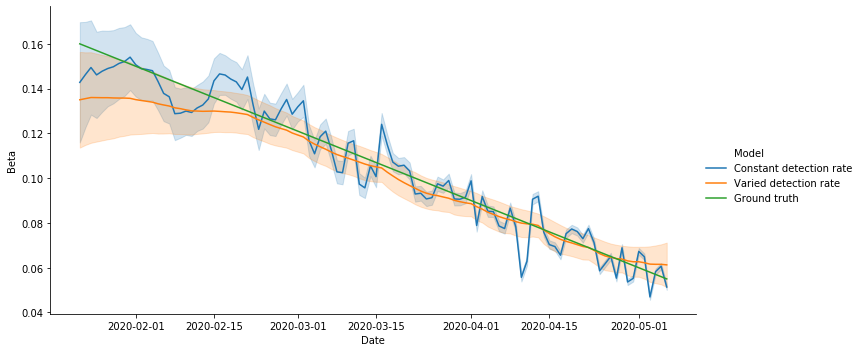

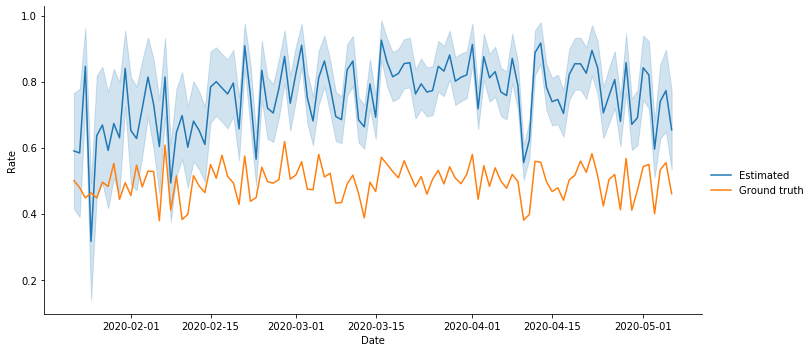

In [15]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
b = extract_var('b', infered_every)
                  
b_true = pd.DataFrame(b_true[:-1], index)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta, 'Ground truth':b_true}, 
     name='trend_beta', label_name='Model', value_name='Beta')

q_true = pd.DataFrame(q_true[:-1], index)
draw({'Estimated':q, 'Ground truth':q_true}, name='trend_q', value_name='Rate', label_name='')

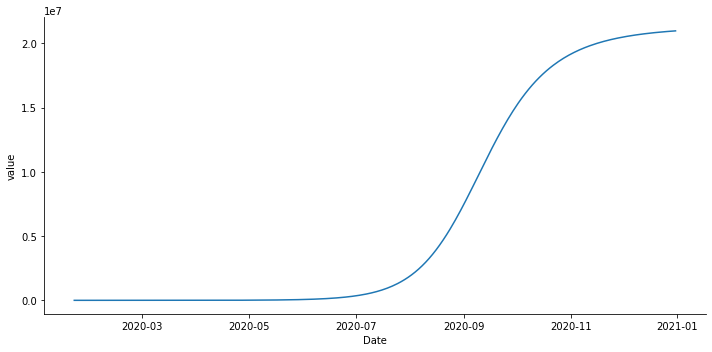

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      49.32   30.53  46.73   2.34   3.54  19.02  99.16 120.53      2   3.38
b_beta       7.7e-5  8.5e-6 2.0e-5 4.6e-5 6.3e-5 7.5e-5 8.9e-5 1.2e-4      5   1.74
b[1]           0.23    0.08   0.13    0.1    0.1   0.24   0.32   0.51      3   4.42
b[2]           0.23    0.08   0.13    0.1    0.1   0.24   0.32   0.51      3   4.42
b[3]           0.23    0.08   0.13    0.1    0.1   0.24   0.32   0.51      3   4.42
b[4]           0.28    0.12   0.19    0.1    0.1   0.24   0.46   0.63      2   6.09
b[5]           0.28    0.12   0.19    0.1    0.1   0.24   0.46   0.63      2   6.09
b[6]           0.27    0.13   0.19    0.1    0.1   0.21   0.46   0.63      2   6.58
b[7]           0.27    0.13   0.19    0.1    0.1   0.21

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      45.81    0.93  14.71  22.85  35.13  43.76  54.43  80.53    251   1.02
b_beta       9.4e-4  1.7e-5 1.7e-4 6.0e-4 8.3e-4 9.4e-4 1.1e-3 1.3e-3     96   1.04
b[1]           0.09  5.5e-4 9.6e-3   0.07   0.09   0.09    0.1   0.11    299   1.02
b[2]           0.09  5.6e-4 9.4e-3   0.07   0.09   0.09    0.1   0.11    286   1.02
b[3]           0.09  5.6e-4 9.3e-3   0.07   0.09   0.09    0.1   0.11    279   1.02
b[4]           0.09  5.5e-4 9.2e-3   0.07   0.09   0.09    0.1   0.11    283   1.02
b[5]           0.09  5.5e-4 9.1e-3   0.07   0.09   0.09    0.1   0.11    275   1.02
b[6]           0.09  5.4e-4 8.9e-3   0.07   0.09   0.09    0.1   0.11    274   1.02
b[7]           0.09  5.3e-4 8.8e-3   0.07   0.09   0.09

In [16]:
#### Saturate ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

index=pd.date_range(start=epoch, end=pd.to_datetime('2020-12-31'))
data = simulate(0.10, 0.2, 100, 0.04, 0.001, 12000_0000,index)
C0 = pd.DataFrame(data['C0'][:-1], index)
draw({'Cumulative':C0})

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)

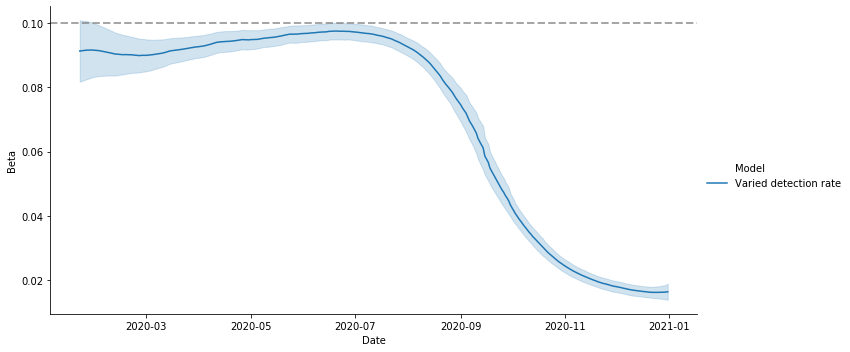

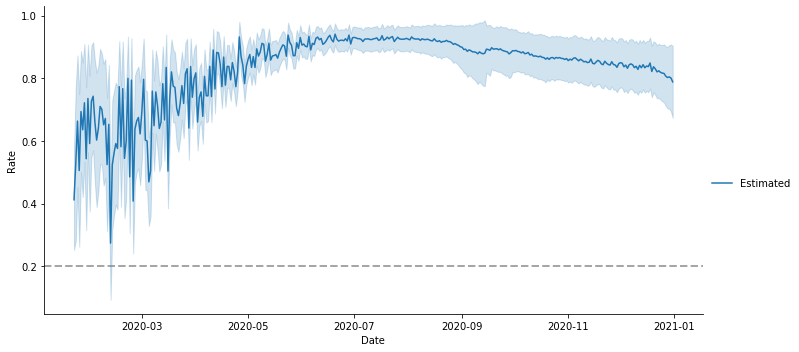

In [17]:
beta_const_q = extract_var('b', infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
draw({'Varied detection rate':beta}, name='saturate_beta', line=0.10, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='saturate_q', value_name='Rate', label_name='')

In [18]:
## Analysis ##
iteration = 10000

In [19]:
### Japanese case ###
P = 126_500_000
infer_const = fit_and_infer(sm=sm_const, country='Japan', population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country='Japan', population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country='Japan', population=P, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      16.82    0.03   3.84   9.93  14.14  16.59  19.33  24.87  20366    1.0
b              0.08  5.5e-6 7.5e-4   0.08   0.08   0.08   0.08   0.08  18404    1.0
q               1.0  2.6e-6 4.5e-4    1.0    1.0    1.0    1.0    1.0  30430    1.0
NI[1]           1.5  6.4e-3   0.91   0.11   0.79    1.4    2.1    3.5  19879    1.0
NI[2]           1.6  6.8e-3   0.95   0.11   0.85    1.5   2.22    3.7  19628    1.0
NI[3]          1.69  7.4e-3    1.0   0.13   0.91   1.59   2.33   3.86  18202    1.0
NI[4]          2.77  6.5e-3   0.99   1.04   2.06   2.71   3.41   4.89  23659    1.0
NI[5]           1.9  7.8e-3   1.09   0.16   1.07    1.8   2.61   4.26  19715    1.0
NI[6]          3.41  6.7e-3   1.05   1.53   2.67   3.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.65  5.9e-3   0.85   0.46   1.05    1.5   2.09   3.74  20488    1.0
b_beta         0.06  5.0e-5 6.9e-3   0.05   0.05   0.06   0.06   0.07  18727    1.0
b[1]           0.09  6.1e-4   0.07 4.2e-3   0.03   0.07   0.12   0.28  14724    1.0
b[2]           0.14  7.9e-4   0.09   0.01   0.07   0.12   0.19   0.36  13217    1.0
b[3]           0.18  8.7e-4    0.1   0.03   0.11   0.17   0.24   0.41  12510    1.0
b[4]           0.23  8.4e-4    0.1   0.07   0.16   0.22   0.28   0.44  13126    1.0
b[5]           0.24  8.6e-4    0.1   0.07   0.17   0.23    0.3   0.46  12823    1.0
b[6]           0.26  8.0e-4   0.09    0.1    0.2   0.25   0.32   0.47  13941    1.0
b[7]           0.26  8.2e-4    0.1   0.09   0.19   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       5.93     0.1   5.82   1.14   2.66   4.18   7.01  21.25   3400    1.0
b_beta         0.01  1.1e-4 3.6e-3 7.3e-3   0.01   0.01   0.02   0.02   1006   1.01
b[1]           0.06  1.2e-3   0.07 1.4e-3   0.01   0.04    0.1   0.22   3045    1.0
b[2]            0.1  1.1e-3   0.07 6.2e-3   0.04   0.09   0.14   0.24   3626    1.0
b[3]           0.12  9.8e-4   0.06   0.02   0.07   0.12   0.16   0.26   4256    1.0
b[4]           0.14  8.5e-4   0.06   0.04    0.1   0.14   0.18   0.26   4587    1.0
b[5]           0.15  7.9e-4   0.05   0.05   0.11   0.15   0.18   0.26   4685    1.0
b[6]           0.16  7.2e-4   0.05   0.07   0.12   0.15   0.19   0.27   4988    1.0
b[7]           0.16  6.8e-4   0.05   0.07   0.13   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one 

         rank      loo    p_loo    d_loo     weight       se      dse warning  \
Varied_q    0  764.809  89.7479        0   0.921278  719.133        0    True   
Const_q     1  774.119  92.0071  9.30963  0.0787223  28.5421  6.26007    True   
Const       2  4611.53  1146.02  3846.72          0  28.1643  748.595    True   

         loo_scale  
Varied_q  deviance  
Const_q   deviance  
Const     deviance  
         rank     waic   p_waic   d_waic     weight       se      dse warning  \
Varied_q    0  695.426  55.0562        0   0.955745  957.358        0    True   
Const_q     1  704.211  57.0531  8.78502  0.0442548  27.3133  3.73972    True   
Const       2  5273.61  1477.05  4578.18          0  28.0206  971.355    True   

         waic_scale  
Varied_q   deviance  
Const_q    deviance  
Const      deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


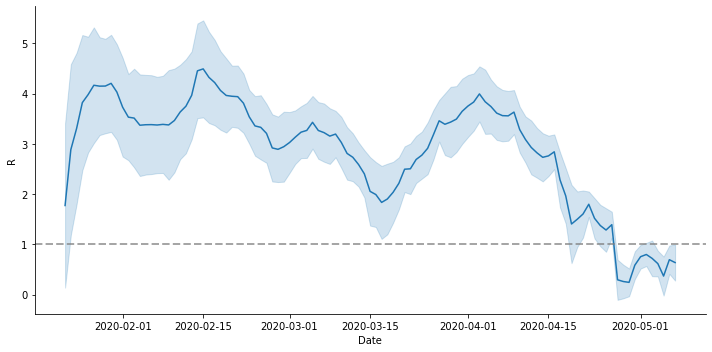

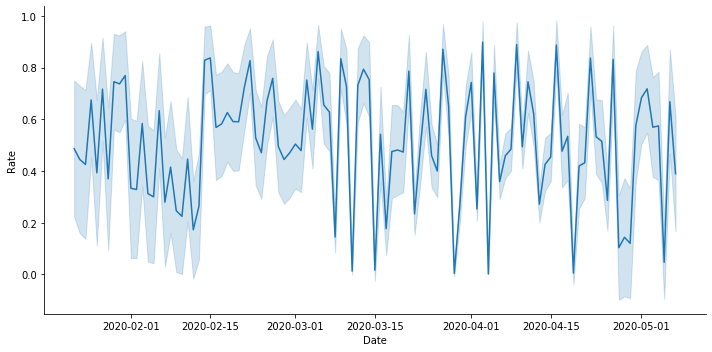

In [20]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_J = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_J}, line=1, name='R_Japan', value_name='R')
draw({'Detection rate':q}, name='q_Japan', value_name='Rate')

In [21]:
#### Sensiticity Analysis ####
infer_s = fit_and_infer(sm=sm_every, country='Japan', population=P, iteration=iteration, b_beta_0=1)
loo = az.loo(infer_s, pointwise=True)
print(loo)
az.compare({'b_beta_0=0.1':infer, 'b_beta_0=1':infer_s})

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       5.81     0.1   5.37   1.14   2.63   4.17    7.0  20.63   3025    1.0
b_beta         0.01  1.0e-4 3.6e-3 7.4e-3   0.01   0.01   0.02   0.02   1174    1.0
b[1]           0.06  1.3e-3   0.07 1.5e-3   0.01   0.04    0.1   0.23   2717    1.0
b[2]            0.1  1.3e-3   0.07 7.3e-3   0.04   0.09   0.14   0.25   2856    1.0
b[3]           0.12  1.1e-3   0.06   0.02   0.07   0.12   0.16   0.26   3316    1.0
b[4]           0.14  9.4e-4   0.06   0.04    0.1   0.14   0.18   0.26   3779    1.0
b[5]           0.15  8.7e-4   0.05   0.05   0.11   0.15   0.18   0.27   3890    1.0
b[6]           0.16  8.2e-4   0.05   0.07   0.12   0.15   0.19   0.27   3860    1.0
b[7]           0.16  7.9e-4   0.05   0.07   0.13   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 107 log-likelihood matrix

       Estimate       SE
IC_loo   764.26    28.90
p_loo     89.51        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5    4.7%
 (0.5, 0.7]   (ok)          8    7.5%
   (0.7, 1]   (bad)        87   81.3%
   (1, Inf)   (very bad)    7    6.5%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
b_beta_0=1,0,695.305,55.0313,0,0.515128,27.2444,0,True,deviance
b_beta_0=0.1,1,695.426,55.0562,0.120887,0.484872,27.2537,0.46682,True,deviance


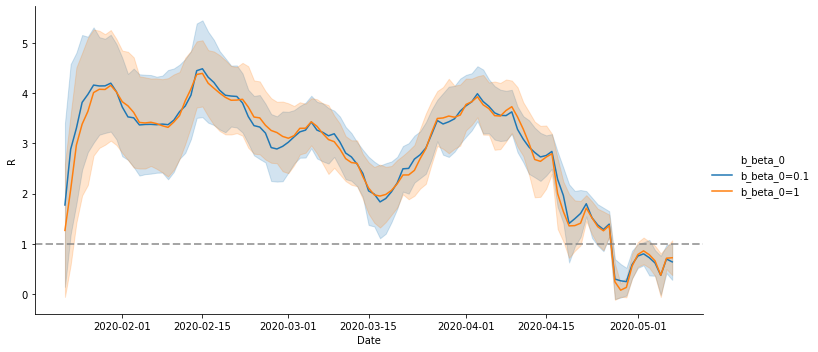

In [46]:
infer = infer_s
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_JS = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)
draw({'b_beta_0=0.1':R_J, 'b_beta_0=1':R_JS}, line=1, name='Sensitivity', 
     value_name='R', label_name='b_beta_0')

In [23]:
### China ###
P = 1_393_000_000
country='China'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     6739.1    0.49  86.08 6569.9 6681.2 6739.2 6797.6 6907.3  30919    1.0
b              0.06  1.4e-6 2.6e-4   0.06   0.06   0.06   0.06   0.06  33059    1.0
q               1.0  2.1e-7 3.7e-5    1.0    1.0    1.0    1.0    1.0  30361    1.0
NI[1]        442.32    0.08  17.42 407.89 430.54 442.21 453.98 476.63  47055    1.0
NI[2]        564.38    0.08  16.76 531.74 553.05 564.47 575.63 597.26  44194    1.0
NI[3]        675.76    0.08  16.39 643.78 664.71 675.68 686.79 707.88  43522    1.0
NI[4]        766.98    0.08  16.61 734.31 755.85 766.92 778.27 799.69  45582    1.0
NI[5]        837.88    0.07  17.04 804.62  826.4  837.7 849.26 871.95  51673    1.0
NI[6]        1319.8    0.08   17.0 1286.4 1308.3 1319

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     556.66    0.17  23.23 511.97 541.04 556.17 572.13  603.1  18493    1.0
b_beta       6.3e-3  8.0e-6 1.1e-3 4.4e-3 5.5e-3 6.2e-3 6.9e-3 8.8e-3  19963    1.0
b[1]           0.17  1.8e-4   0.03   0.12   0.15   0.17   0.19   0.23  23693    1.0
b[2]           0.47  1.6e-4   0.02   0.44   0.46   0.47   0.49   0.51  14964    1.0
b[3]           0.48  1.6e-4   0.02   0.44   0.46   0.48   0.49   0.51  13495    1.0
b[4]           0.47  1.5e-4   0.02   0.44   0.46   0.47   0.48   0.51  14162    1.0
b[5]           0.46  1.7e-4   0.02   0.42   0.45   0.46   0.48    0.5  12458    1.0
b[6]           0.98  2.2e-4   0.03   0.91   0.96   0.98    1.0   1.04  22828    1.0
b[7]           0.11  4.3e-5 6.8e-3    0.1   0.11   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     9860.9   29.81 1393.0 7587.1 8917.6 9718.8  1.1e4  1.3e4   2184    1.0
b_beta       1.0e-3 10.0e-6 2.4e-4 6.2e-4 8.4e-4 9.8e-4 1.1e-3 1.5e-3    569   1.02
b[1]           0.16  1.9e-4 9.7e-3   0.14   0.16   0.16   0.17   0.18   2536    1.0
b[2]           0.16  1.9e-4 9.6e-3   0.14   0.16   0.16   0.17   0.18   2488    1.0
b[3]           0.16  1.9e-4 9.5e-3   0.14   0.16   0.16   0.17   0.18   2426    1.0
b[4]           0.16  1.9e-4 9.5e-3   0.14   0.16   0.16   0.17   0.18   2378    1.0
b[5]           0.16  2.0e-4 9.4e-3   0.14   0.16   0.16   0.17   0.18   2280    1.0
b[6]           0.16  2.0e-4 9.3e-3   0.14   0.16   0.16   0.17   0.18   2253    1.0
b[7]           0.16  2.0e-4 9.2e-3   0.14   0.16   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with 

         rank      loo    p_loo   d_loo      weight       se      dse warning  \
Varied_q    0  957.153  89.7119       0    0.999023  18362.6        0    True   
Const_q     1  987.264  102.113  30.111  0.00097675  24.2327  8.26438    True   
Const       2  42077.1   3947.6   41120           0  23.7237  18592.1    True   

         loo_scale  
Varied_q  deviance  
Const_q   deviance  
Const     deviance  
         rank     waic   p_waic   d_waic       weight       se      dse  \
Varied_q    0  881.577  51.9238        0     0.999124  27358.5        0   
Const_q     1  900.035  58.4979  18.4575  0.000875589  23.7904  5.55606   
Const       2  58341.7  12079.9  57460.2            0  22.6699  27440.6   

         warning waic_scale  
Varied_q    True   deviance  
Const_q     True   deviance  
Const       True   deviance  


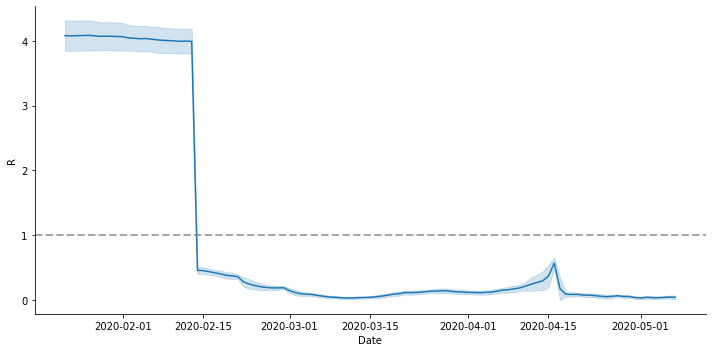

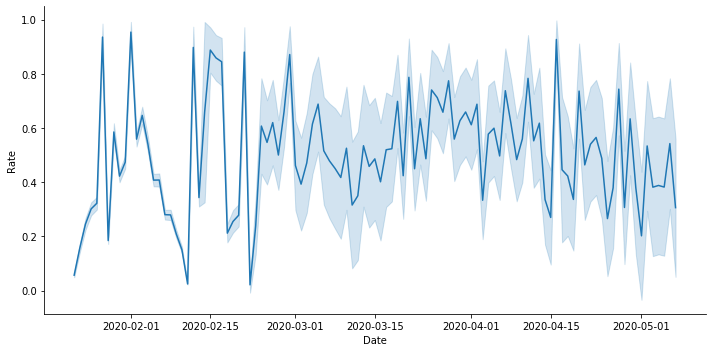

In [24]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_C = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_C}, line=1, name='R_China', value_name='R')
draw({'Detection rate':q}, name='q_China', value_name='Rate')

In [25]:
### US ###
P = 327_200_000
country='US'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      328.9    0.11  19.29 291.77  315.8 328.63 341.77 367.71  28741    1.0
b              0.08  5.5e-7 8.3e-5   0.08   0.08   0.08   0.08   0.08  22203    1.0
q               1.0  9.2e-8 1.4e-5    1.0    1.0    1.0    1.0    1.0  24040    1.0
NI[1]         28.58    0.03   4.97  18.83  25.21  28.57   31.9  38.48  27419    1.0
NI[2]          31.8    0.03   5.17  21.65  28.32  31.77  35.26   42.1  27137    1.0
NI[3]         33.53    0.03   5.37   23.1  29.94  33.54  37.14  44.02  26509    1.0
NI[4]          38.7    0.03   5.33  28.38  35.05  38.67  42.27  49.23  28721    1.0
NI[5]         39.48    0.03   5.59  28.65   35.7  39.47  43.23  50.63  27798    1.0
NI[6]         42.75    0.03   5.81  31.55   38.8  42.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.46  6.0e-3   0.81   0.35   0.89   1.32   1.86   3.45  17771    1.0
b_beta         0.03  5.2e-5 4.8e-3   0.02   0.02   0.03   0.03   0.04   8406    1.0
b[1]           0.06  4.6e-4   0.05 3.0e-3   0.02   0.04   0.08   0.19  11703    1.0
b[2]           0.09  5.3e-4   0.05   0.02   0.05   0.08   0.12   0.23  10549    1.0
b[3]           0.11  5.8e-4   0.06   0.02   0.07    0.1   0.14   0.24   9287    1.0
b[4]           0.13  5.7e-4   0.05   0.04   0.09   0.12   0.16   0.25   9401    1.0
b[5]           0.12  6.3e-4   0.06   0.03   0.08   0.12   0.16   0.25   8021    1.0
b[6]           0.12  6.7e-4   0.06   0.03   0.08   0.12   0.16   0.25   7088    1.0
b[7]           0.12  6.7e-4   0.06   0.03   0.08   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       3.08    0.03   2.54   0.65   1.57   2.41   3.75   9.65   6325    1.0
b_beta         0.02  8.0e-5 3.5e-3 9.6e-3   0.01   0.01   0.02   0.02   1934    1.0
b[1]           0.05  5.9e-4   0.05 2.1e-3   0.02   0.04   0.07   0.18   6694    1.0
b[2]           0.08  6.2e-4   0.05   0.01   0.04   0.07   0.11    0.2   6411    1.0
b[3]            0.1  6.1e-4   0.05   0.02   0.06   0.09   0.12   0.21   6209    1.0
b[4]           0.11  6.2e-4   0.05   0.04   0.07    0.1   0.13   0.22   5576    1.0
b[5]           0.11  6.2e-4   0.05   0.04   0.08    0.1   0.14   0.21   5390    1.0
b[6]           0.11  6.1e-4   0.04   0.04   0.08   0.11   0.14   0.21   5289    1.0
b[7]           0.11  6.0e-4   0.04   0.04   0.08   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one 

         rank     loo    p_loo    d_loo      weight       se      dse warning  \
Varied_q    0  1030.9  89.0713        0    0.999997  12598.4        0    True   
Const_q     1  1084.7   110.44  53.7941  3.4316e-06  66.1448  19.2163    True   
Const       2  133706    13047   132675           0  60.0697  12766.5    True   

         loo_scale  
Varied_q  deviance  
Const_q   deviance  
Const     deviance  
         rank     waic   p_waic  d_waic       weight       se      dse  \
Varied_q    0  966.983  57.1106       0     0.999997  20594.5        0   
Const_q     1  1014.91  75.5467  47.929  2.95121e-06  62.3106  17.6833   
Const       2   202119  47253.6  201152            0  55.7801  20719.2   

         warning waic_scale  
Varied_q    True   deviance  
Const_q     True   deviance  
Const       True   deviance  


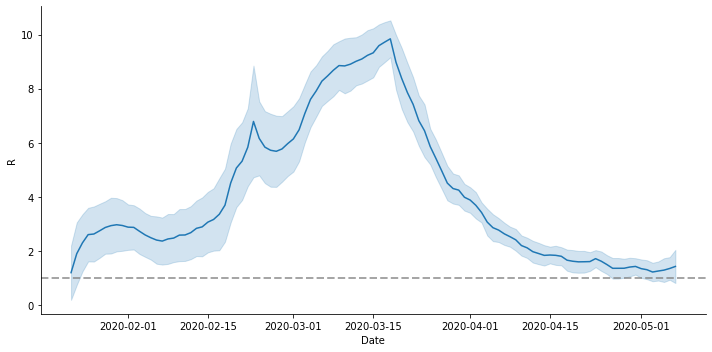

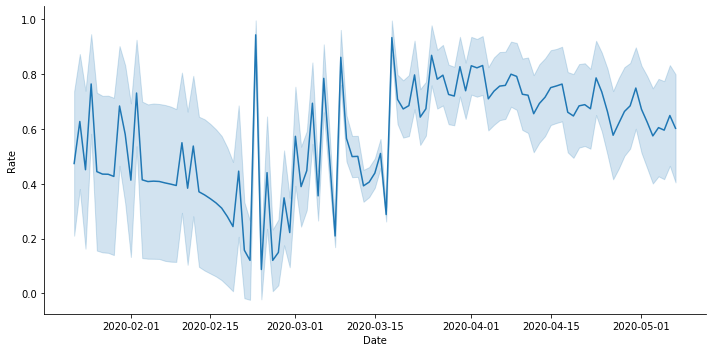

In [26]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_US = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_US}, line=1, name='R_US', value_name='R')
draw({'Detection rate':q}, name='q_US', value_name='Rate')

In [27]:
### Italy ###
P = 60_360_000
country='Italy'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    1077.3    0.25  35.97 1008.1 1052.8 1076.9 1101.7 1148.3  20065    1.0
b             0.07  1.1e-6 1.6e-4   0.07   0.07   0.07   0.07   0.07  20359    1.0
q              1.0  3.2e-7 4.7e-5    1.0    1.0    1.0    1.0    1.0  21773    1.0
NI[1]        74.92    0.06   8.33  58.66  69.32  74.81  80.56  91.21  21219    1.0
NI[2]        79.89    0.06   8.41  63.39  74.27  79.78  85.53  96.62  20976    1.0
NI[3]        85.38    0.06   8.46  68.63  79.74  85.43  91.05 101.82  20079    1.0
NI[4]         91.2    0.06   8.59  74.37  85.33  91.13  97.07 108.01  19822    1.0
NI[5]        97.23    0.06   8.92  79.74  91.27  97.15 103.23 114.82  21429    1.0
NI[6]       104.63    0.06   9.01  87.24  98.53  104.6 110.61 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      1.86    0.01   1.02   0.48   1.12   1.66   2.38   4.36   9646    1.0
b_beta        0.01  2.9e-5 2.6e-3   0.01   0.01   0.01   0.02   0.02   7615    1.0
b[1]          0.02  2.2e-4   0.02 1.1e-3 8.6e-3   0.02   0.03   0.09  10561    1.0
b[2]          0.04  2.9e-4   0.03 3.0e-3   0.02   0.03   0.05   0.11   8780    1.0
b[3]          0.05  3.3e-4   0.03 5.8e-3   0.03   0.04   0.06   0.12   8283    1.0
b[4]          0.06  3.8e-4   0.03 8.6e-3   0.03   0.05   0.07   0.13   7108    1.0
b[5]          0.06  4.2e-4   0.03   0.01   0.04   0.06   0.08   0.14   6258    1.0
b[6]          0.07  5.0e-4   0.03   0.02   0.04   0.07   0.09   0.15   4642    1.0
b[7]          0.07  7.3e-4   0.04   0.01   0.05   0.07   0.09 

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      2.41    0.08    3.0   0.43   1.16   1.81   2.83    7.5   1552    1.0
b_beta        0.01  7.4e-5 2.8e-3 5.7e-3 8.2e-3 9.8e-3   0.01   0.02   1390    1.0
b[1]          0.04  2.0e-3   0.06 7.6e-4 6.4e-3   0.01   0.03   0.27   1037    1.0
b[2]          0.07  3.2e-3   0.09 2.5e-3   0.01   0.03   0.07   0.35    804   1.01
b[3]          0.09  3.5e-3    0.1 4.7e-3   0.02   0.05    0.1   0.37    818   1.01
b[4]          0.11  3.9e-3   0.11 7.2e-3   0.03   0.06   0.14   0.38    787    1.0
b[5]          0.13  4.4e-3   0.12   0.01   0.04   0.08   0.21    0.4    734    1.0
b[6]          0.16  4.7e-3   0.12   0.02   0.06    0.1   0.26   0.42    694    1.0
b[7]          0.17  4.8e-3   0.13   0.02   0.06   0.12   0.28 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one 

         rank      loo    p_loo    d_loo   weight       se      dse warning  \
Varied_q    0  958.414   83.716        0  0.47337  4346.75        0    True   
Const_q     1  960.049  83.3137   1.6351  0.52663  47.7365  20.7187    True   
Const       2  41400.5  6418.64  40442.1        0  41.1937  4333.67    True   

         loo_scale  
Varied_q  deviance  
Const_q   deviance  
Const     deviance  
         rank     waic   p_waic   d_waic    weight       se      dse warning  \
Varied_q    0  888.134  48.5759        0  0.583292  6418.17        0    True   
Const_q     1  892.254  49.4161  4.12024  0.416708  42.0995  13.0094    True   
Const       2  57048.3  14242.5  56160.2         0  38.4307  6485.57    True   

         waic_scale  
Varied_q   deviance  
Const_q    deviance  
Const      deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


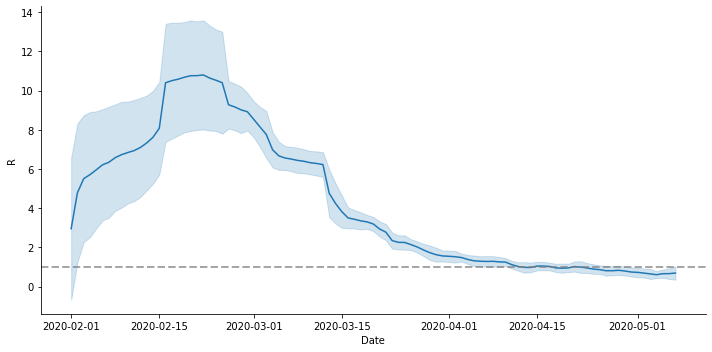

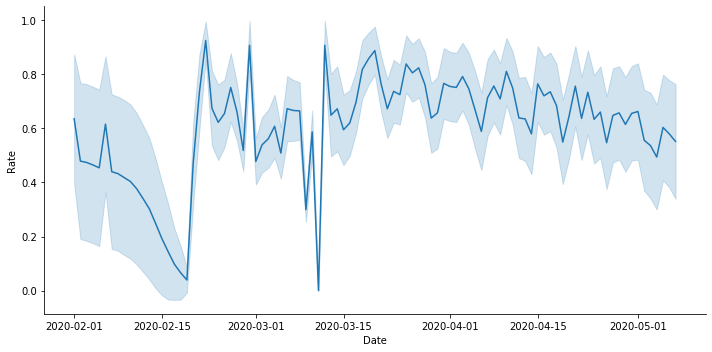

In [28]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_I = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_I}, line=1, name='R_Italy', value_name='R')
draw({'Detection rate':q}, name='q_Italy', value_name='Rate')

In [29]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     150.21    0.07  13.88 123.97 140.54 149.91 159.41 178.41  35135    1.0
b              0.06  3.9e-6 7.0e-4   0.06   0.06   0.06   0.06   0.06  32728    1.0
q               1.0  2.0e-6 3.5e-4    1.0    1.0    1.0    1.0    1.0  32298    1.0
NI[1]           9.6    0.02   2.98   3.78   7.59   9.63  11.59  15.55  22211    1.0
NI[2]         11.03    0.02    2.9   5.48   9.06  10.99  12.95  16.88  34907    1.0
NI[3]         10.81    0.02   3.05   4.89   8.79  10.77  12.85  16.79  25234    1.0
NI[4]         12.29    0.02   3.01   6.48  10.22  12.26  14.28  18.22  34787    1.0
NI[5]          13.0    0.02   3.04   7.16  10.94  12.99  15.03  19.08  35311    1.0
NI[6]         12.97    0.02   3.19    6.7  10.82  12.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.52    0.02   1.39   0.68   1.53   2.23   3.19   5.99   8235    1.0
b_beta       8.6e-3  2.5e-5 1.6e-3 5.9e-3 7.5e-3 8.5e-3 9.6e-3   0.01   4113    1.0
b[1]           0.06  1.1e-3   0.05 1.2e-3   0.01   0.04    0.1   0.18   2519    1.0
b[2]           0.09  8.7e-4   0.05   0.01   0.05   0.09   0.12    0.2   3318    1.0
b[3]            0.1  7.7e-4   0.05   0.02   0.07    0.1   0.13    0.2   3591    1.0
b[4]           0.11  6.6e-4   0.04   0.03   0.08   0.11   0.14    0.2   4048    1.0
b[5]           0.12  6.0e-4   0.04   0.05   0.09   0.11   0.14    0.2   4255    1.0
b[6]           0.12  5.7e-4   0.04   0.05   0.09   0.12   0.14    0.2   4423    1.0
b[7]           0.12  5.2e-4   0.04   0.06    0.1   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     519.28  371.25 621.39   0.38   1.19   3.82 1081.8 1756.2      3    1.9
b_beta       2.4e-3  2.3e-410.0e-4 1.1e-3 1.7e-3 2.2e-3 2.9e-3 4.8e-3     18    1.1
b[1]           0.13    0.09   0.13 2.7e-4 1.9e-3   0.16   0.26    0.3      2   5.43
b[2]           0.13    0.09   0.13 6.4e-4 2.7e-3   0.16   0.26    0.3      2   5.34
b[3]           0.13    0.09   0.13 4.8e-4 2.9e-3   0.16   0.26    0.3      2   5.35
b[4]           0.13    0.09   0.13 8.0e-4 3.3e-3   0.16   0.26    0.3      2   5.34
b[5]           0.14    0.09   0.13 8.4e-4 3.5e-3   0.17   0.26    0.3      2   5.35
b[6]           0.14    0.09   0.13 6.3e-4 3.6e-3   0.17   0.26    0.3      2   5.37
b[7]           0.14    0.09   0.13 7.4e-4 4.1e-3   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with 

         rank      loo    p_loo    d_loo     weight       se      dse warning  \
Varied_q    0  743.801  84.8183        0   0.975833  1305.52        0    True   
Const_q     1  784.086   95.105  40.2846  0.0241672   40.213  26.7551    True   
Const       2  7175.16  1379.74  6431.36          0  27.0488  1243.64    True   

         loo_scale  
Varied_q  deviance  
Const_q   deviance  
Const     deviance  
         rank     waic   p_waic   d_waic       weight       se      dse  \
Varied_q    0  676.836  51.3357        0     0.999773  1470.28        0   
Const_q     1  727.959  67.0413  51.1225  0.000227103   38.433  26.2051   
Const       2  7887.09   1735.7  7210.25            0  25.9009  1532.41   

         warning waic_scale  
Varied_q    True   deviance  
Const_q     True   deviance  
Const       True   deviance  


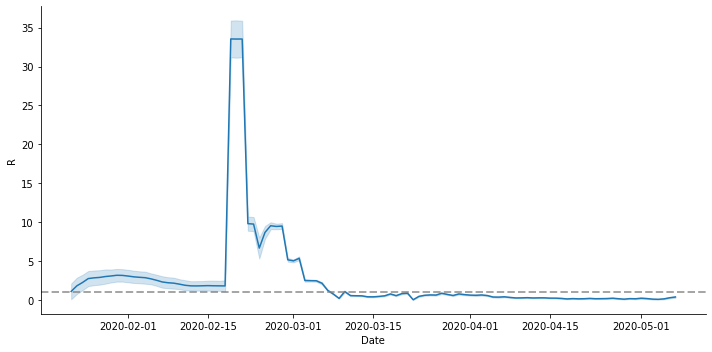

In [30]:
beta = extract_var(var_name='b', data=infer_const_q)
C = extract_var(var_name='C', data=infer_const_q)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K}, line=1, name='R_Korea', value_name='R')

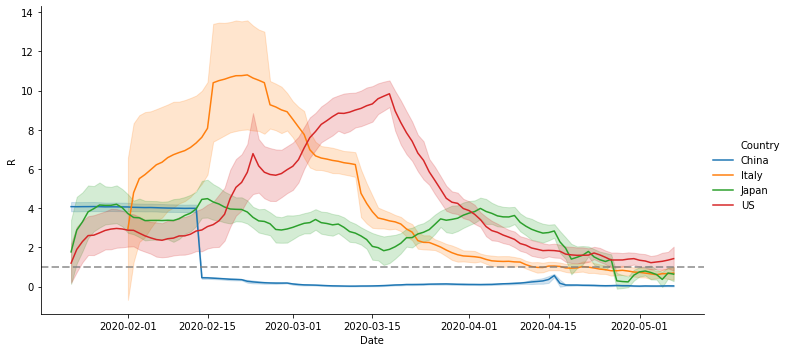

In [31]:
draw({'China':R_C, 'Italy':R_I, 'Japan':R_J, 'US':R_US}, line=1, name='R_multi', value_name='R', label_name='Country')

In [32]:
### Sweden ###
P = 10_230_000
country='Sweden'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     28.74    0.03   5.64  18.58  24.83  28.45  32.37  40.54  26977    1.0
b             0.08  3.9e-6 5.7e-4   0.08   0.08   0.08   0.08   0.08  21280    1.0
q              1.0  5.7e-6 9.8e-4    1.0    1.0    1.0    1.0    1.0  29457    1.0
NI[1]          2.5  9.5e-3   1.29    0.3   1.55   2.43   3.35   5.23  18249    1.0
NI[2]         2.65    0.01   1.36   0.31   1.64   2.58   3.55   5.52  16032    1.0
NI[3]         2.84    0.01   1.42   0.35    1.8   2.75   3.78   5.77  16738    1.0
NI[4]         3.04    0.01   1.49    0.4   1.95   2.97   4.04   6.14  16795    1.0
NI[5]         3.28    0.01   1.52   0.56   2.17   3.21   4.29    6.4  19820    1.0
NI[6]          3.5    0.01   1.56   0.62   2.37   3.45   4.55 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      0.67  4.0e-3    0.5   0.07   0.31   0.56    0.9   1.93  15313    1.0
b_beta        0.02  4.2e-5 3.7e-3   0.02   0.02   0.02   0.03   0.03   7524    1.0
b[1]          0.03  2.1e-4   0.03 1.3e-3   0.01   0.02   0.04    0.1  15172    1.0
b[2]          0.04  2.9e-4   0.03 2.8e-3   0.02   0.04   0.06   0.12  11780    1.0
b[3]          0.05  3.4e-4   0.04 4.3e-3   0.03   0.05   0.07   0.14  10375    1.0
b[4]          0.06  3.9e-4   0.04 5.4e-3   0.03   0.05   0.08   0.15   9459    1.0
b[5]          0.06  4.3e-4   0.04 6.8e-3   0.04   0.06   0.09   0.16   8690    1.0
b[6]          0.07  4.7e-4   0.04 6.8e-3   0.04   0.06   0.09   0.17   7930    1.0
b[7]          0.07  4.9e-4   0.04 8.7e-3   0.04   0.07    0.1 

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      1.25    0.01   0.96   0.18   0.62   1.04   1.62   3.65   8520    1.0
b_beta        0.01  8.9e-5 3.3e-3 7.0e-3   0.01   0.01   0.01   0.02   1410    1.0
b[1]          0.02  3.0e-4   0.02 8.8e-4 7.6e-3   0.02   0.03   0.09   6204    1.0
b[2]          0.04  4.4e-4   0.03 2.6e-3   0.02   0.03   0.05   0.11   4346    1.0
b[3]          0.05  5.0e-4   0.03 4.6e-3   0.02   0.04   0.06   0.13   4177    1.0
b[4]          0.05  5.7e-4   0.04 6.9e-3   0.03   0.05   0.07   0.14   3790    1.0
b[5]          0.06  6.3e-4   0.04 8.8e-3   0.03   0.05   0.08   0.15   3560    1.0
b[6]          0.07  6.9e-4   0.04   0.01   0.04   0.06   0.09   0.16   3261    1.0
b[7]          0.07  7.7e-4   0.04   0.01   0.04   0.07    0.1 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one 

         rank      loo    p_loo    d_loo       weight       se      dse  \
Varied_q    0  709.208  67.9908        0            1  323.287        0   
Const_q     1  787.505  95.9454  78.2974  1.38557e-09  50.8698   26.191   
Const       2  3157.59  706.638  2448.38            0   40.882  305.265   

         warning loo_scale  
Varied_q    True  deviance  
Const_q     True  deviance  
Const       True  deviance  
         rank     waic   p_waic   d_waic       weight       se      dse  \
Varied_q    0  654.566  40.6698        0            1   363.83        0   
Const_q     1  726.708  65.5469  72.1425  1.46032e-08  46.9459  26.6527   
Const       2  3246.54  751.114  2591.97            0  36.8256  352.886   

         warning waic_scale  
Varied_q    True   deviance  
Const_q     True   deviance  
Const       True   deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


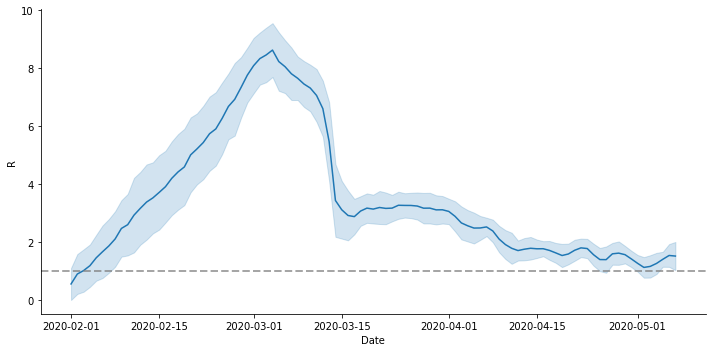

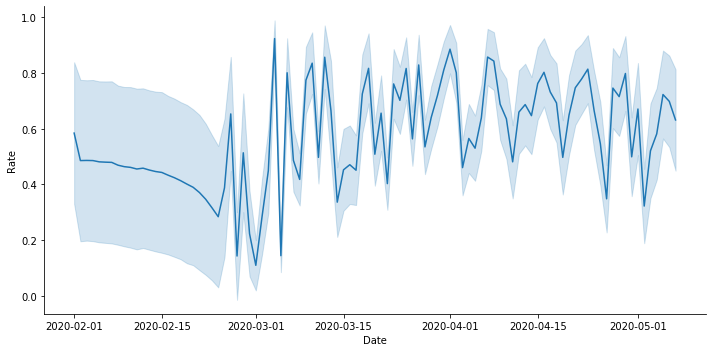

In [33]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_S = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_S}, line=1, name='R_Sweden', value_name='R')
draw({'Detection rate':q}, name='q_Sweden', value_name='Rate')

In [34]:
### Denmark ###
P = 5_806_000
country='Denmark'
start=pd.to_datetime('2020-03-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     272.5    0.13  16.92 240.46 260.81 272.18 283.76 306.51  18041    1.0
b             0.07  5.8e-6 8.0e-4   0.07   0.07   0.07   0.07   0.07  19372    1.0
q              1.0  9.3e-6 1.5e-3   0.99    1.0    1.0    1.0    1.0  26428    1.0
NI[1]        19.43    0.03    4.2  11.06  16.63  19.44  22.29  27.61  20496    1.0
NI[2]        22.49    0.03   4.12  14.46  19.66  22.46  25.28  30.65  24865    1.0
NI[3]        25.92    0.03   4.06  18.01  23.17  25.91  28.61  33.91  23297    1.0
NI[4]        23.77    0.03   4.53   14.7  20.77  23.76  26.83  32.57  23717    1.0
NI[5]        33.43    0.03   4.06  25.61  30.65  33.35  36.14  41.52  24108    1.0
NI[6]         27.1    0.03   4.69  17.89  23.97  27.12  30.28 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      2.98    0.08   1.74    0.8    1.7   2.58   3.86    7.3    505   1.01
b_beta        0.01  1.3e-4 3.1e-3 8.5e-3   0.01   0.01   0.02   0.02    549   1.01
b[1]          0.28    0.05   0.34 8.7e-4   0.01   0.08   0.45    1.1     56   1.09
b[2]           0.6    0.03   0.35   0.05   0.34   0.51   0.91    1.3    185   1.02
b[3]          0.64    0.02   0.33   0.17   0.36   0.53   0.93   1.32    202   1.02
b[4]          0.64    0.02   0.33   0.17   0.37   0.53   0.93   1.33    202   1.02
b[5]          0.66    0.02   0.33    0.2   0.38   0.55   0.94   1.35    216   1.01
b[6]          0.66    0.02   0.34   0.19   0.38   0.55   0.95   1.36    215   1.01
b[7]          0.96    0.04   0.45   0.31   0.53   0.96   1.31 

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      4.75    0.21   5.26   1.37   2.69   3.83   5.52  12.39    626   1.01
b_beta      8.4e-3  8.7e-5 2.6e-3 4.5e-3 6.6e-3 8.0e-3 9.7e-3   0.01    867   1.01
b[1]          0.57    0.09   0.29 1.3e-3   0.56   0.67   0.75    0.9     10   1.66
b[2]          0.71  4.2e-3    0.1   0.52   0.64   0.71   0.77   0.91    572   1.01
b[3]          0.71  4.2e-3    0.1   0.52   0.65   0.71   0.77   0.91    556   1.01
b[4]          0.71  4.3e-3    0.1   0.53   0.65   0.71   0.77   0.91    536   1.01
b[5]          0.71  4.2e-3    0.1   0.53   0.65   0.71   0.77   0.91    534   1.01
b[6]          0.71  4.2e-3    0.1   0.53   0.65   0.71   0.77   0.91    528   1.01
b[7]          0.71  4.2e-3    0.1   0.53   0.65   0.71   0.77 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:

         rank      loo    p_loo    d_loo        weight       se      dse  \
Varied_q    0  600.295  58.8256        0      0.999761  238.269        0   
Const_q     1  662.514  86.1562  62.2188   0.000238995  28.5227  29.2736   
Const       2  2282.04  500.699  1681.74  5.76162e-216  12.5673   242.02   

         warning loo_scale  
Varied_q    True  deviance  
Const_q     True  deviance  
Const       True  deviance  
         rank     waic   p_waic   d_waic        weight       se      dse  \
Varied_q    0  551.393  34.3745        0      0.999988  260.347        0   
Const_q     1  612.952  61.3754  61.5594   1.24129e-05  29.8098  30.4453   
Const       2  2272.56  495.962  1721.17  2.78847e-243  11.6907  255.694   

         warning waic_scale  
Varied_q    True   deviance  
Const_q     True   deviance  
Const       True   deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


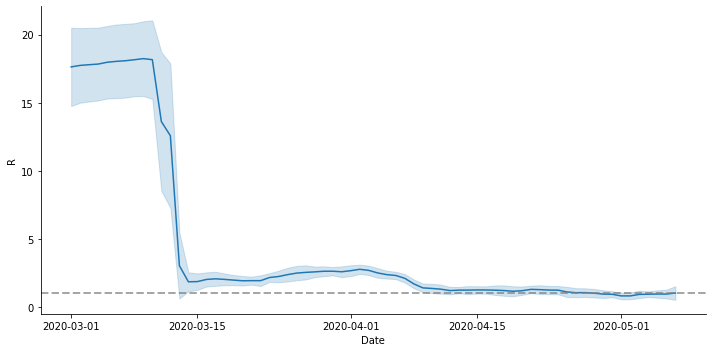

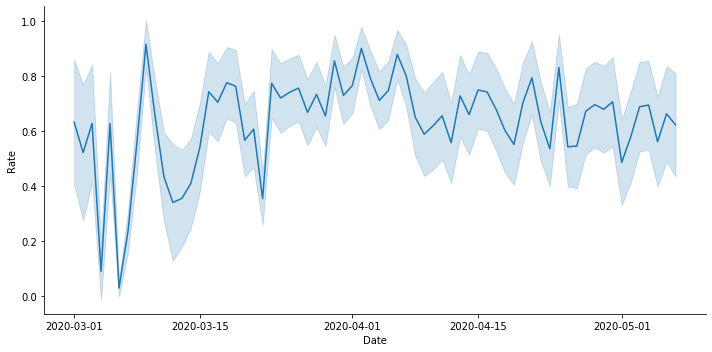

In [37]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_D = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_D}, line=1, name='R_Denmark', value_name='R')
draw({'Detection rate':q}, name='q_Denmark', value_name='Rate')

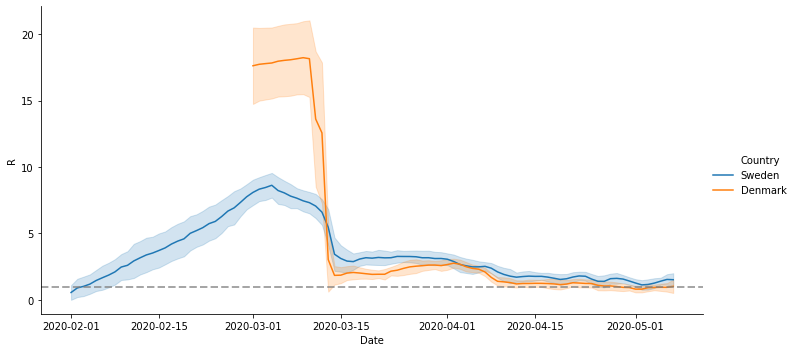

In [38]:
draw({'Sweden':R_S, 'Denmark':R_D,}, line=1, name='R_Nordic', value_name='R', label_name='Country')

In [39]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_1 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer_01 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
                        detection_rate=0.1)
infer_001 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
                        detection_rate=0.01)
infer_0001 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
                        detection_rate=0.001)
# infer_0 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
#                         detection_rate=0)
loo = az.loo(infer_1, pointwise=True)
print(az.compare({'1':infer_1, '0.1':infer_01, '0.01':infer_001, '0.001':infer_0001}, ic='loo'))
print(az.compare({'1':infer_1, '0.1':infer_01, '0.01':infer_001, '0.001':infer_0001}, ic='waic'))

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.47    0.02   1.36   0.65    1.5   2.19   3.14   5.85   6867    1.0
b_beta       8.7e-3  2.5e-5 1.6e-3 5.9e-3 7.6e-3 8.6e-3 9.7e-3   0.01   4211    1.0
b[1]           0.06  1.2e-3   0.06 1.2e-3   0.01   0.04    0.1   0.19   2255    1.0
b[2]           0.09  9.8e-4   0.05   0.01   0.05   0.09   0.13    0.2   2746    1.0
b[3]            0.1  8.6e-4   0.05   0.02   0.07    0.1   0.13    0.2   2947    1.0
b[4]           0.11  7.6e-4   0.04   0.03   0.08   0.11   0.14    0.2   3132    1.0
b[5]           0.12  6.9e-4   0.04   0.05   0.09   0.12   0.14    0.2   3393    1.0
b[6]           0.12  6.5e-4   0.04   0.05   0.09   0.12   0.14    0.2   3444    1.0
b[7]           0.12  6.0e-4   0.04   0.06    0.1   0.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      24.36    0.33  17.17   3.48  11.68  20.35  32.78  67.67   2714    1.0
b_beta         0.01  2.4e-5 1.7e-3 7.1e-3 8.8e-3 9.9e-3   0.01   0.01   5462    1.0
b[1]           0.14  2.9e-3    0.1 2.0e-3   0.02   0.14   0.21   0.34   1295    1.0
b[2]           0.19  2.0e-3   0.08   0.03   0.13   0.18   0.24   0.36   1821    1.0
b[3]           0.19  1.8e-3   0.08   0.05   0.14   0.19   0.24   0.36   1945    1.0
b[4]            0.2  1.6e-3   0.07   0.08   0.15   0.19   0.24   0.36   2059    1.0
b[5]            0.2  1.5e-3   0.07   0.09   0.16    0.2   0.24   0.36   2052    1.0
b[6]            0.2  1.5e-3   0.07    0.1   0.16    0.2   0.24   0.36   2042    1.0
b[7]           0.21  1.4e-3   0.06    0.1   0.16    0

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     257.71    3.38 175.18  34.87 128.82 219.15 343.83 699.16   2694    1.0
b_beta         0.01  2.3e-5 1.8e-3 7.3e-3 9.1e-3   0.01   0.01   0.01   6417    1.0
b[1]           0.15  3.7e-3   0.12 2.1e-3   0.02   0.15   0.23    0.4   1103   1.01
b[2]            0.2  2.3e-3    0.1   0.03   0.14    0.2   0.26   0.42   1666    1.0
b[3]           0.21  2.2e-3   0.09   0.05   0.15    0.2   0.26   0.41   1727    1.0
b[4]           0.22  2.0e-3   0.08   0.08   0.16   0.21   0.26   0.41   1829    1.0
b[5]           0.22  1.9e-3   0.08    0.1   0.17   0.21   0.26   0.41   1793    1.0
b[6]           0.22  1.8e-3   0.08    0.1   0.17   0.21   0.26   0.41   1790    1.0
b[7]           0.22  1.8e-3   0.08   0.11   0.17   0.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     2268.0   48.54 1681.7  34.11 1065.2 1906.8 3079.5 6551.8   1200   1.01
b_beta         0.01  3.0e-5 2.1e-3 8.7e-3   0.01   0.01   0.01   0.02   4847    1.0
b[1]           0.19    0.02   0.22 2.2e-3   0.03   0.17   0.26   0.88    106   1.04
b[2]           0.25    0.02    0.2   0.04   0.15   0.21   0.28   0.89    104   1.04
b[3]           0.26    0.02    0.2   0.06   0.17   0.22   0.29   0.88    102   1.04
b[4]           0.27    0.02   0.19   0.09   0.18   0.23   0.29   0.89    100   1.04
b[5]           0.27    0.02   0.19   0.11   0.18   0.23   0.29   0.89     99   1.04
b[6]           0.27    0.02   0.19   0.11   0.18   0.23   0.29   0.89     98   1.04
b[7]           0.27    0.02   0.19   0.12   0.19   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with 

      rank      loo    p_loo    d_loo     weight       se      dse warning  \
1        0  784.418  95.3087        0   0.615012  40.7942        0    True   
0.001    1   790.69  91.6753  6.27198   0.190303  43.4995  14.7128    True   
0.01     2  791.571  90.2678  7.15228   0.149638   42.442   15.004    True   
0.1      3  793.266  92.3393  8.84755  0.0450461  42.7684  12.1471    True   

      loo_scale  
1      deviance  
0.001  deviance  
0.01   deviance  
0.1    deviance  
      rank     waic   p_waic    d_waic     weight       se      dse warning  \
0.1      0  727.253  59.3326         0     0.2409  39.1048        0    True   
1        1  728.046  67.1226  0.793635   0.501363  37.6716  19.7024    True   
0.001    2   729.36  61.0101   2.10735   0.163211   38.705  2.68219    True   
0.01     3   730.56  59.7624   3.30729  0.0945261  38.7108  2.17702    True   

      waic_scale  
0.1     deviance  
1       deviance  
0.001   deviance  
0.01    deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


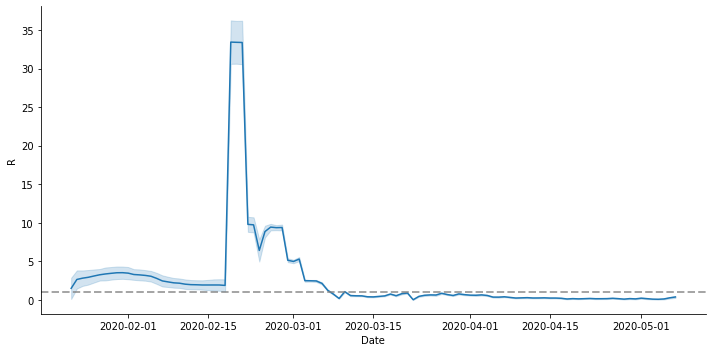

In [40]:
infer=infer_1
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K1 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K1}, line=1, name='R_Korea1', value_name='R')

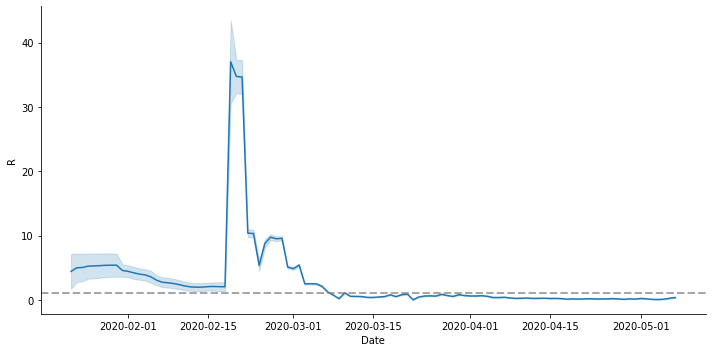

In [41]:
infer=infer_01
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K01 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K01}, line=1, name='R_Korea01', value_name='R')

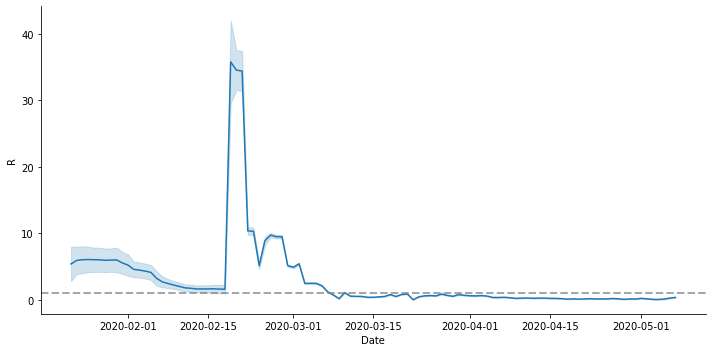

In [42]:
infer=infer_001
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K001 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K001}, line=1, name='R_Korea001', value_name='R')

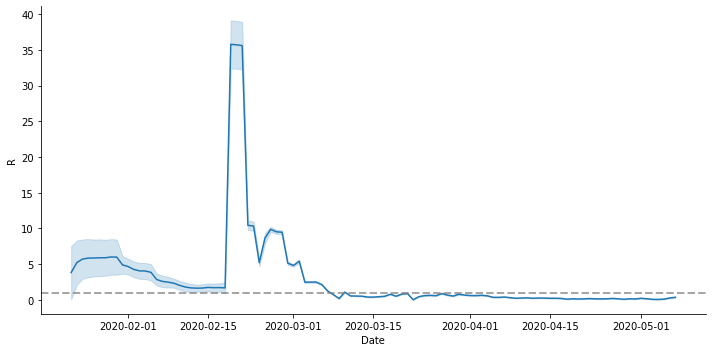

In [43]:
infer=infer_0001
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K0001 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K0001}, line=1, name='R_Korea0001', value_name='R')

In [44]:
az.compare({'1':infer_1, '0.1':infer_01, '0.01':infer_001, '0.001':infer_0001}, ic='loo')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
1,0,784.418,95.3087,0,0.599686,42.353,0,True,deviance
0.001,1,790.69,91.6753,6.27198,0.188714,45.5685,14.7128,True,deviance
0.01,2,791.571,90.2678,7.15228,0.167014,44.5195,15.004,True,deviance
0.1,3,793.266,92.3393,8.84755,0.0445861,44.6848,12.1471,True,deviance


In [45]:
az.compare({'1':infer_1, '0.1':infer_01, '0.01':infer_001, '0.001':infer_0001}, ic='waic')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
0.1,0,727.253,59.3326,0,0.240985,37.3678,0,True,deviance
1,1,728.046,67.1226,0.793635,0.519766,36.7391,19.7024,True,deviance
0.001,2,729.36,61.0101,2.10735,0.148569,37.8178,2.68219,True,deviance
0.01,3,730.56,59.7624,3.30729,0.0906802,37.6964,2.17702,True,deviance
